# <center><font size=10>随机森林</font></center>


## 本课程需要使用的module: os, numpy, pandas, tensorflow(2.0.0及以上), matplotlib, sklearn, graphviz, pydotplus, skimage, opencv, seaborn.


# <span id='content'>目录</span>

## [0. 课程摘要](#0)

## [1. 决策树](#1)

## [2. 分类决策树](#2)

## [3. 回归决策树](#3)

## [4. 本课任务介绍](#4)

### [- 4.1 MNIST介绍](#4.1)

### [- 4.2 数据的预处理](#4.2)

## [5. 随机森林](#5)

### [- 5.1 分类式随机森林](#5.1)

### [- 5.2 回归式随机森林](#5.2)

### [- 5.3 预测错误展示](#5.3)

## [6. 非数据库图片测试](#6)

## [7. 总结](#7)

# Homework

## [作业1](#HW1)

## [作业2](#HW2)

## [作业3](#HW3)

## [作业4](#HW4)

## [作业5](#HW5)

# 加载library

## 首先让我们将需要的module准备好。

In [1]:
#!pip install scikit-image
#!pip install pydotplus

In [2]:
import tensorflow as tf    #tensorflow: conda install tensorflow
import graphviz    #graphviz: conda install python-graphviz
from IPython.display import Image #图像处理及输出 conda install ipython
import pandas as pd    #pandas: conda install pandas
import pydotplus    #pydotplus: pip install pydotplus
import numpy as np    #numpy: conda install numpy
import os #读取文件路径module
import random #随机数生成module
import matplotlib.pyplot as plt #绘图module
from warnings import simplefilter
import seaborn as sns
import cv2
import sklearn
simplefilter(action='ignore', category=FutureWarning)#避免大量的FutureWarning

# <span id="0">0. 课程摘要</span>
前一部分的课程给大家介绍了分类和回归问题的处理方法，这一课给大家介绍一种既可以用于回归问题，也可以用于分类问题的算法：**随机森林**。

随机森林是一种灵活，易于使用的机器学习算法，即使没有超参数调整，也能在大多数情况下产生出色的结果。

本课内容包括随机森林的组成部分：决策树的原理和生成，随机森林的原理、生成。我们将使用随机森林模型解决一个有趣的问题：手写数字识别问题。

<br/>**随机森林**是由不同的**决策树**组成的，所以首先给大家介绍**决策树**。



# <span id="1">1. 决策树</span>

决策树是一种二叉树。在计算机科学中，二叉树（英语：Binary tree）是每个节点最多只有两个分支（即不存在分支度大于2的节点）的树结构。通常分支被称作“左子树”或“右子树”。二叉树的分支具有左右次序，不能随意颠倒。




### 树的相关知识：

> 节点的度：一个节点含有的子树的个数称为该节点的度；
<br><br>树的度：一棵树中，最大的节点度称为树的度；
<br><br>叶节点或终端节点：度为零的节点；
<br><br>父亲节点或父节点：若一个节点含有子节点，则这个节点称为其子节点的父节点；
<br><br> 孩子节点或子节点：一个节点含有的子树的根节点称为该节点的子节点；
<br><br>兄弟节点：具有相同父节点的节点互称为兄弟节点；
<br><br>节点的层次：从根开始定义起，根为第1层，根的子节点为第2层，以此类推；
<br><br>深度：对于任意节点n,n的深度为从根到n的唯一路径长，根的深度为0；
<br><br>高度：对于任意节点n,n的高度为从n到一片树叶的最长路径长，所有树叶的高度为0；



### 例：此处我们以iris dataset的分类问题建立一个决策树。

In [3]:
from sklearn.datasets import load_iris #鸢尾花数据集
from sklearn import tree #决策树module
#使用iris数据集
iris = load_iris()

#样例：分类树
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)
dot_data = tree.export_graphviz(clf, out_file=None, 
feature_names=iris.feature_names,  
class_names=iris.target_names,  
filled=True, rounded=True,  
special_characters=True                                
)

#作图
graph = pydotplus.graph_from_dot_data(dot_data)
img = Image(graph.create_png())
graph.write_png("Example_1.png")
#下面进行决策树图片的输出

True

<img src="Example_1.png" style="zoom:65%" />
<br/><center><font size=5>Example 1: A decision tree for the iris dataset</font></center>

<br/><font size=4> 
    图注： 
    - sample：该节点所包含的样本数量。
    
    - value：该节点中样本对应的各类鸢尾花的数量，该list中第一个元素为山鸢尾数量，第二个为变色鸢尾数量，第三个为维吉尼亚鸢尾数量。
    
    - class：该节点的输出（山鸢尾 (Setosa)、变色鸢尾 (Versicolour) 和维吉尼亚鸢尾 (Virginica)）
    
    - gini：该节点的基尼指数。
    
    - 颜色：该节点的输出。褐色为山鸢尾，绿色为变色鸢尾，紫色为维吉尼亚鸢尾。深浅度代表了所得结果的概率大小。
    
    决策树以基尼指数(gini)为拓展分支的准则，在下面的内容里我们将介绍这一重要概念。
</font>



# <span id="2">2. 分类决策树</span>

#### 分类树分析是当预计结果可能为离散类型（例如三个种类的花，输赢等）使用的概念。

- 特征和特征数值如何选取：

    - 基尼指数
        - 基尼指数$Gini(D)$表示集合$D$不确定性，基尼指数$Gini(D，A=a)$表示集合D经$A=a$分割后的不确定性(类似于熵)，
        - 基尼指数越小，样本的不确定性越小。
        - 基尼值是指从一个样本集中选择2个样本，这2个样本不属于同一类的概率：
        $$ Gini(D)=\sum^K_{k=1}p_k(1-p_k)=1-\sum^K_{k=1}p_k^2 $$
        $$ Gini(D,A=a)=\frac{D_1}{D}Gini(D1)+\frac{D_2}{D}Gini(D2)=\sum^V_{v=1}\frac{|D_v|}{|D|}Gini(D_v) $$
    - 通过基尼指数选择特征
        - 可以看出基尼值越小说明该数据集中不同类的数据越少，即数据集纯度越高。
        - 在所有可能的特征A以及该特征所有的可能取值$a$中，选择基尼指数最小的特征及其对应的取值作为最优特征和最优切分点。

        当特征A所对应的值为连续值时，对样本的特征A的值$a$进行升序排序，从小到大取相邻两个值的平均值作为阈值进行划分，在所有切分点中，基尼指数最小的即为最优切分点。

### 例：以体重与患心脏病情况的关系为例来说明如何生成分类二叉树。

Source: https://www.youtube.com/watch?v=7VeUPuFGJHk&t=779s


<br/><img src="classifier_tree_1.png" style="zoom:45%" />
<br/><center><font size=3 color="blue">这是该问题的一个简单的数据集。</font></center>

<br/><img src="classifier_tree_2.png" style="zoom:45%" />
<br/><center><font size=3 color="blue">第一步，将样本按照连续型特征的大小进行排序。</font></center>

<br/><img src="classifier_tree_3.jpg" style="zoom:35%" />
<br/><center><font size=3 color="blue">第二步，计算两相邻样本该特征的平均值，作为备选的切分点。</font></center>

<br/><img src="classifier_tree_4.jpg" style="zoom:40%" />
<br/><center><font size=2 color="blue">例：计算基尼指数。</font></center>
<br/><img src="classifier_tree_5.jpg" style="zoom:40%" />
<br/><center><font size=3 color="blue">第三步，计算每个切分点对应的基尼指数。</font></center>

<br/><img src="regression_tree_3.png" style="zoom:50%" />
<br/><img src="regression_tree_3.1.jpeg" style="zoom:30%" />
<br/><center><font size=3 color="blue">寻找函数最小值所对应的切分点特征及其取值，即为最佳切分点。</font></center>

<br/><img src="classifier_tree_6.jpg" style="zoom:70%" />
<br/><center><font size=3 color="blue">第四步，选取最小基尼指数对应的切分点作为最终切分点。</font></center>

<br/><center><font size=3 color="blue">第五步，对每个子节点循环第二步～第四步直至无法再分。</font></center>

### <span id='HW1'>作业1</span>：
写一个函数来计算基尼指数。**（请在编写代码部分完成作业1）**

In [4]:
######Mission 1: Compute Gini coefficient.######


#问题描述: 现有一贷款申请样本数据表，

#共15组样本，4个特征，

#特征的取值是离散的，

#输出为申请贷款结果class，

#现需要根据样本数据表计算各种分割方式的基尼指数。


#####################################

    
    



In [5]:
#此处为讲解基尼指数的计算方法和过程加载贷款申请样本数据表
#读取数据集
dataset = pd.read_csv(r"datasetForGini.csv")
#输出数据集
print(dataset,"\n")

      age work house     credit   class
0   youth   no    no     common  refuse
1   youth   no    no       good  refuse
2   youth  yes    no       good   agree
3   youth  yes   yes     common   agree
4   youth   no    no     common  refuse
5     mid   no    no     common  refuse
6     mid   no    no       good  refuse
7     mid  yes   yes       good   agree
8     mid   no   yes  excellent   agree
9     mid   no   yes  excellent   agree
10  elder   no   yes  excellent   agree
11  elder   no   yes       good   agree
12  elder  yes    no       good   agree
13  elder  yes    no  excellent   agree
14  elder   no    no     common  refuse 



In [6]:
#获得特征种类
features = []
#了解特征详情
for i in dataset.columns:
    features.append(i)

features.pop()#不要最后一列的标签（指class：agree/refuse）

print("特征有:",features)


特征有: ['age', 'work', 'house', 'credit']


**编写代码部分：**

In [7]:
#设计Gini函数求基尼指数，其中参数dataset是数据集，feature为所选特征，value为所选特征的取值(当然也可以不使用这里给出的参数)。
#这个函数返回对应特征取值得到的基尼指数(保留两位小数)。
#提示：根据之前给出的计算公式设计此函数
#pd.DataFrame(dataset[features])
def Gini(dataset,feature,value):
    stack=[]
    stackDic={}
    for row in dataset.itertuples():
        if value in row:
            stack.append(row[1:])
    for temp in stack:
        if(temp not in stackDic.keys()):
            stackDic[temp]=1
        else:
            stackDic[temp]+=1
    p=0
    for temp in stackDic.keys():
        p+=(stackDic[temp]*stackDic[temp]/(len(stackDic)*len(stackDic)))
    return round(1-p,2)
    

In [8]:
#进行基尼指数输出
print("选择的特征是age，取值是youth, 基尼指数为： ",Gini(dataset,'age','youth'))

print("选择的特征是age，取值是elder, 基尼指数为： ",Gini(dataset,'age','elder'))

print("选择的特征是work，取值是yes, 基尼指数为： ",Gini(dataset,'work','yes'))

print("选择的特征是house，取值是no, 基尼指数为： ",Gini(dataset,'house','no'))

print("选择的特征是house，取值是yes, 基尼指数为： ",Gini(dataset,'house','yes'))

print("选择的特征是credit，取值是common, 基尼指数为： ",Gini(dataset,'credit','common'))

print("选择的特征是credit，取值是good, 基尼指数为： ",Gini(dataset,'cresit','good'))

选择的特征是age，取值是youth, 基尼指数为：  0.56
选择的特征是age，取值是elder, 基尼指数为：  0.8
选择的特征是work，取值是yes, 基尼指数为：  0.83
选择的特征是house，取值是no, 基尼指数为：  0.86
选择的特征是house，取值是yes, 基尼指数为：  0.83
选择的特征是credit，取值是common, 基尼指数为：  0.56
选择的特征是credit，取值是good, 基尼指数为：  0.83


**决策树的输出值为树叶上大多数样本所属的类别：**

如上图例1所示，每个节点都有一个class数据成员。

譬如训练样本包括A,B,C三个类别，某一树叶上对应8个A类样本，2个B类样本，1个C类样本，那么这个树叶的输出则是A类别。


**附：其它选择特征的方式**：

**信息熵**(information entropy)是度量样本集合纯度的一种常用指标。

我们可以通过与之相关的**信息增益**选取特征。

（简单了解即可）

# <span id="3">3. 回归决策树</span>

回归决策树是可以用于回归的决策树模型，一个回归树对应着输入空间（即特征空间）的一个划分以及在划分单元上的输出值。

在生成和输出过程中，回归决策树和分类决策树主要有两点不同：

- 特征选择

假设X和Y分别为输入和输出变量，并且Y是连续变量，给定训练数据集为$D=\left \{ (x_1,y_1 ),(x_2,y_2 ),...,(x_N,y_N) \right \}$，其中$\small x_i=(x_{i}^{(1)},x_{i}^{(2)},...,x_{i}^{(n)})$为输入实例(特征向量)，n为特征个数，i=1,2,...,N, N为样本容量。

特征$j$和特征取值$s$：

$$R_1(j,s)={x|x^{(j)}<=s}$$
$$R_2(j,s)={x|x^{(j)}>s}$$
$$min_{j,s}{[\sum_{x_i\in R_1{(j,s)}}({y_i-\hat{c_1}})^2+\sum_{x_i\in R_2{(j,s)}}({y_i-\hat{c_2}})^2]} $$

其中$\small \hat{c_1}=\frac{1}{N_1}\sum_{x_i\in R_1(j,s)}y_i$，   $\small \hat{c_2}=\frac{1}{N_2}\sum_{x_i\in R_2(j,s)}y_i$。

找到最优的切分点$(j,s)$后，依次将输入空间划分为两个区域，接着对每个区域重复上述划分过程，直到满足停止条件为止。这样就生成了一棵回归树，这样的回归树通常称为最小二乘回归树。

- 输出值

输出值为单元内每个样本点的值的均值。

### 例：药物剂量
Source: https://www.youtube.com/watch?v=g9c66TUylZ4&t=769s
#### 此视频中的问题是一个单特征问题（Drug-Effective - Drug Dosage）。

<br/><img src="regression_tree_1.1.png" style="zoom:30%" />
<br/><center><font size=3 color="blue">这是本例所使用的数据集，</font></center>

<br/><img src="regression_tree_1.2.png" style="zoom:60%" />
<br/><center><font size=3 color="blue">这是根据数据集画出的散点图，使用它来进行讲解。</font></center>

<br/><img src="regression_tree_2.1.jpg" style="zoom:40%" />
<br/><center><font size=3 color="blue">首先我们选取切分点进行切分，将所有数据点根据切分条件（红线）分入两个子集$s_1,s_2$（图左侧），</font></center>
<br/><center><font size=3 color="blue">其次我们计算每个样本点的预测值与所属子集的所有样本点观测值的平均值的平方差（图右侧），</font></center>
<br/><center><font size=3 color="blue">将所有平方差作求和得到最终的目标函数，是一个关于切分点取值的函数。</font></center>

<br/><img src="regression_tree_2.2.jpg" style="zoom:40%" />
<br/><center><font size=3 color="blue">之后我们更换切分点取值，再进行一次上述操作</font></center>

# <span id="4">4. 本课任务介绍：手写数字识别问题</span>

输入为手写数字数据集，样本为三维数组$x_i\in R^ {N\times s_1\times s_2}$，每个样本对应0~9中的一个数字。

**作为10类别分类问题，输出为0~9。**

**也可以作为回归问题处理。**


## <span id="4.1">4.1 MNIST介绍</span>

MNIST数据集(Mixed National Institute of Standards and Technology database)是美国国家标准与技术研究院收集整理的大型手写数字数据库。

In [9]:
sns.set_style('white')

#加载MNIST数据集
hand_written_digits = list(tf.keras.datasets.mnist.load_data()[0])



#取前12000个样本
#获得样本X
hand_written_digits[0]=hand_written_digits[0][0:12000]
#获得标签y
hand_written_digits[1]=hand_written_digits[1][0:12000]


### <span id='HW2'>作业2：</span>
补充下一个代码块使其能够按顺序展示0～9，每个标签各一个样本。

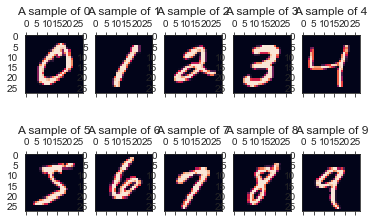

In [10]:
#添加代码使mnist_example从hand_written_digits处获得样本。
mnist_example=[];
for i in range(10):
    for j in range(1000):
        if(hand_written_digits[1][j]==i):
            mnist_example.append(hand_written_digits[0][j])
            break;
for i in range(1,len(mnist_example)+1):
    ax=plt.subplot(2,5,i)
    ax.matshow(mnist_example[i-1])
    ax.set_title("A sample of %d\n"%(i-1))
plt.show()



所以，我们这次课的任务具体地说，则是：

**建立一个模型：**
- 输入为一个包含手写文字的图片，尺寸大小是28*28，合计 $28\times28=784$个特征。

- 输出为手写文字图片对应的数字。


## <span id="4.2">4.2 数据的预处理</span>

1. 扁平化：使二维数组（矩阵）一维化（向量）以便于处理数据

2. 二值化：使元素取值取0或255，设定一个阈值，大于此阈值的元素取255，小于此阈值的元素取0。

In [11]:
#数据扁平化
dataLen=len(hand_written_digits[0])
flattenData=np.reshape(hand_written_digits[0],(dataLen,28*28))

'''二值化：使元素取值取0或255
设定一个阈值，大于此阈值的元素取255，小于此阈值的元素取0'''
def binarization(data,threshold):
    for i in data:
        for j in range(len(i)):
            if i[j]>=threshold:
                i[j]=255
            else:
                i[j]=0
    return data  

flattenData=binarization(flattenData,100)
# 扁平化后的数据集shape
print(flattenData.shape)
print(hand_written_digits[0].shape)

(12000, 784)
(12000, 28, 28)


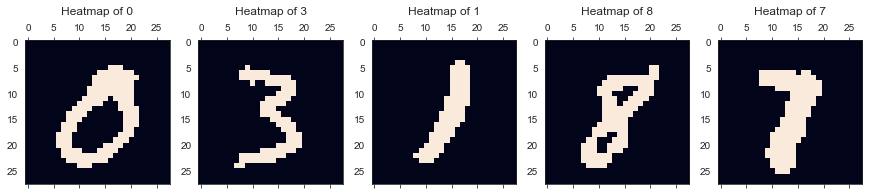

In [12]:
#数据可视化(Heatmap)
#二值化后的Heatmap

#随机选取5个样本进行展示
indexs=np.random.randint(200,size=5)

plt.figure(figsize=(15,8))  
i=0
for index in indexs:
    ax=plt.subplot(1,len(indexs),i+1)
    ax.matshow(hand_written_digits[0][index])
    ax.set_title("Heatmap of %d\n"%(hand_written_digits[1][index]))
    i+=1

plt.show() 

<center><font size=4 color="red">可以看出，经过二值化的样本的热图不再有渐变色，因为每个像素点的取值非0即255。</font></center>

# <span id="5">5. 随机森林</span>

在机器学习中，随机森林是一个包含多个决策树的分类器，并且其输出的类别是由个别树输出的类别的众数而定。 Leo Breiman和Adele Cutler发展出推论出随机森林的算法。

随机森林就是通过集成学习的思想将多棵树集成的一种算法，它的基本单元是决策树，而它的本质属于机器学习的一大分支——集成学习（Ensemble Learning）方法。

### 随机森林可以看作是决策树的组合
1. 树的数量的影响（训练时间、欠拟合/过拟合）
2. 随机抽取样本进行决策树的构造
3. 随机抽取特征进行决策树的构造


### 随机森林的随机性

- 样本的随机性

如果训练集大小为N，对于每棵树而言，随机且有放回地从训练集中的抽取N个训练样本，作为该树的训练集。（询问家人、朋友的意见时，每个人以前去过的旅游地是不一样的，所以训练集是不同的。这其实是bagging。）
- 特征的随机性

如果每个样本的特征维度为M，指定一个常数m<<M，随机地从M个特征中选取m个特征子集，每次树进行分裂时，从这m个特征中选择最优的。（询问家人、朋友的意见时，每个人考虑的要素是不同的，有人考虑价格，有人考虑交通，所以特征的选取是不同的）


### 数据集的划分

**随机森林是一种监督学习的算法，所以我们要对数据集进行划分：将其划分为训练集和测试集**

### <span id='HW3'>作业3：</span>
复习sklearn.model_selection.train_test_split函数并将hand_written_digits进行数据集划分，测试集大小为数据集的四分之一
<br>**注：hand_written_digits[0]为数据集X，hand_written_digits[1]为标签集y。**

In [13]:
#划分数据集
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(hand_written_digits[0], hand_written_digits[1], test_size=0.25)

#使数据集中样本数据扁平化
X_train=np.reshape(X_train,(9000,28*28))
X_test=np.reshape(X_test,(3000,28*28))

## <span id="5.1">5.1 分类式随机森林</span>

分类式随机森林由多棵分类决策树构成。

<img src="racoon.png" style="zoom:80%">
<center><font size=4 color=blue>一个分类式随机森林的例子</font><center>
<br/><font size=3>
    图注：
    每棵树是一颗分类决策树，对输入给出自己的结果，最后综合所有决策树的结果给出随机森林的结果。
</font>

In [14]:
#样例：随机森林及其参数
from sklearn.ensemble import RandomForestClassifier

rfc_example = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None,
                                     min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                     max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07,
                                     bootstrap=True, oob_score=False, n_jobs=1, random_state=None, 
                                     verbose=0,warm_start=False, class_weight=None)

### <span id='rfc'>Sklearn分类式随机森林函数中的参数</span>

1. criterion: ”gini” or “entropy”(default=”gini”)是计算属性的gini(基尼指数)还是entropy(信息增益)，来选择最合适的节点。

2. max_depth: (default=None)设置树的最大深度，默认为None，这样建树时，会使每一个叶节点只有一个类别，或是达到min_samples_split。

3. min_samples_split: 根据属性划分节点时，每个划分最少的样本数。

4. n_estimators: 决策树的个数。

5. oob_score=False：oob（out of bag，袋外）数据，即：在某次决策树训练中没有被bootstrap选中的数据。

6. n_jobs=1：并行job个数。可通过并行提高性能。(n_job=-1时，有多少个core就可以启动多少个job)



### 将问题视为分类问题：

In [15]:
#构造随机森林（默认参数，使用n_jobs=-1来加速训练速度）

rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train, y_train)
print("Score = ",rfc.score(X_test, y_test))

Score =  0.913


### 超参数对模型性能的影响

- 过拟合：

模型过于复杂会导致过拟合，表现为在训练集上的得分较高，但是泛化能力差，在测试集上的得分较低。

在本问题中，max_depth过大或n_estimator过大会导致过拟合。

- 欠拟合：

模型过于简单会导致欠拟合，表现为在训练集上和在测试集上得分都较低。

在本问题中，max_depth过大或n_estimator过低会导致过拟合。

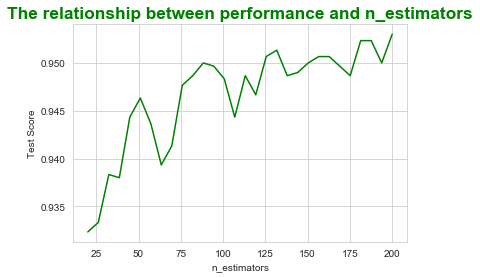

In [16]:
sns.set_style("whitegrid")
#观察决策树数目对模型accuracy的影响
x=np.linspace(20,200,30)
y=[]
for i in np.linspace(20,200,30):
    rfc_i = RandomForestClassifier(n_estimators=int(i+0.5),n_jobs=-1)
    rfc_i.fit(X_train, y_train)
    y.append(rfc_i.score(X_test, y_test))
#画图观察performance-n_estimators关系
plt.plot(x,y,c="g")
plt.title("The relationship between performance and n_estimators",fontsize='xx-large',fontweight='heavy',color="green")
plt.xlabel("n_estimators")
plt.ylabel("Test Score")
plt.show()

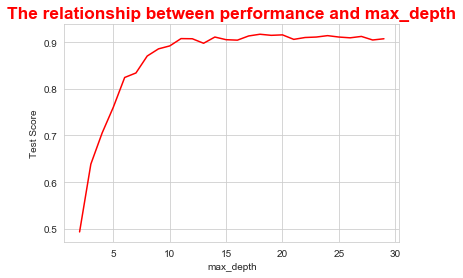

In [17]:
#观察决策树最大深度对模型accuracy的影响
x=np.linspace(2,29,28)
y=[]
for i in range(2,30):
    rfc_i = RandomForestClassifier(max_depth=i,n_jobs=-1)
    rfc_i.fit(X_train, y_train)
    y.append(rfc_i.score(X_test,y_test))
plt.plot(x,y,c="r")
plt.title("The relationship between performance and max_depth",fontsize='xx-large',fontweight='heavy',color="red")
plt.xlabel("max_depth")
plt.ylabel("Test Score")

plt.show()

**可以看出，在本问题中，所选择的两个参数取值过小会导致欠拟合，但取值较大时并不容易产生过拟合（随着参数取值的不断增大，模型性能没有减弱）。**

In [18]:
#rfct为最终选择的随机森林模型
rfct = RandomForestClassifier(n_estimators=100,max_depth=25)
rfct.fit(X_train, y_train)
print("测试分数 = ",rfct.score(X_test, y_test))
#用一个list存放被错误分类的数据信息
w=[]
for i in range(len(X_test)):
    pred=rfct.predict(X_test[i].reshape(1,-1))[0]
    if pred!=y_test[i]:
        w.append([X_test[i],pred,y_test[i]])


测试分数 =  0.949


### 分类式随机森林决策过程：

### <span id='HW4'>作业4</span>：
观察统计随机森林中所有决策树对某一个样本预测的结果。绘制柱状图。

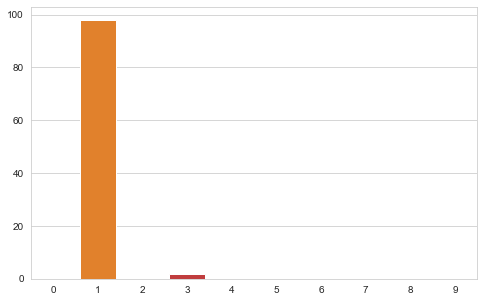

正确答案是:  1


In [19]:
# 补充该cell。
plt.figure(figsize=(8,5))
#调取随机森林模型的estimators_数据成员以获取随机森林中决策树们的信息
Estimators = rfct.estimators_
x=np.arange(0,10)

#此处以数组y来统计vote结果。
y=np.zeros(10,dtype="int")

#随机选取一个样本
random_index=random.randint(0,200)

#补充此处：统计所有决策树对X_test[random_index]给出的结果
#提示：使用enumerate, 获取模型对样本的预测可以使用int(model.predict(X_test[random_index].reshape(1,-1))[0])。
for decisionTree in Estimators:
    y[int(decisionTree.predict(X_test[random_index].reshape(1,-1))[0])]+=1;

ax = sns.barplot(x=x, y=y)

#补充此处：绘制统计结果的柱状图，X轴为标签0～9，Y轴为投票结果。
#提示：使用sns.barplot()函数。

plt.show()

print("正确答案是: ",y_test[random_index])

分类式随机森林中的每个决策树都得出结果后，所有决策树会进行一次**majority vote**。每个决策树为自己所得的结果投票， **<font size=4>得票最多的结果</font>** 就是随机森林得到的结果。上图中votes为每个可能结果所得的票数。

## <span id="5.2">5.2 回归式随机森林</span>

回归式随机森林由多棵回归决策树构成。

### 让我们先来看看sklearn的回归式随机森林函数

In [20]:
sns.set_style('white')
from sklearn.ensemble import RandomForestRegressor

rfr_example=RandomForestRegressor(n_estimators=10, criterion='mse', 
                                             max_depth=None, min_samples_split=2, 
                                             min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                             max_features='auto', max_leaf_nodes=None, 
                                             bootstrap=True, oob_score=False, 
                                             n_jobs=1, random_state=None, 
                                             verbose=0, warm_start=False)

#### 和[分类式随机森林函数](#rfc)区别不大。

### 将问题视为回归问题：

1. 最后输出结果会是一个实数，而不是一个分类标签。
2. 汇总各个决策树的预测时可以求平均。
3. 最终的预测结果可以是四舍五入的结果（譬如随机森林给出汇总结果为5.7，则预测为数字6）


In [21]:
#建立随机森林（回归决策树，默认参数）
rfr=RandomForestRegressor(n_jobs=-1)
rfr.fit(X_train,y_train)
#输出测试分数
print("训练分数:",rfr.score(X_train,y_train))
print("测试分数:",rfr.score(X_test,y_test))



训练分数: 0.9615301799881242
测试分数: 0.8136096839957903


In [22]:
#相同hyperparameter下的回归分类树的效果
rfrt=RandomForestRegressor(n_estimators=100,max_depth=25)
rfrt.fit(X_train,y_train)
#输出测试分数
print("训练分数:",rfrt.score(X_train,y_train))
print("测试分数:",rfrt.score(X_test,y_test))

#用一个list存放被错误分类的数据信息
w_r=[]
for i in range(len(X_test)):
    #由于使用round函数存在偶尔四舍五入不准的情况，此处使用另一种方法
    pred=int(rfrt.predict(X_test[i].reshape(1,-1))[0]+0.5)
    if pred!=y_test[i]:
        w_r.append([X_test[i],pred,y_test[i]])

训练分数: 0.976784823880736
测试分数: 0.8475895999518365


## <span id="5.3">5.3 预测错误展示 </span>

### 让我们观察一下在两种随机森林的分类错误测试样本：

In [23]:
#从分类树中选取被错误分类的数据
#分类模型将向量二维化
for i in range(len(w)):
    w[i][0]=w[i][0].reshape(28,28)
#回归模型将向量二维化
for i in range(len(w_r)):
    w_r[i][0]=w_r[i][0].reshape(28,28)





### 首先是分类模型的预测错误 

错误分类(分类模型)：



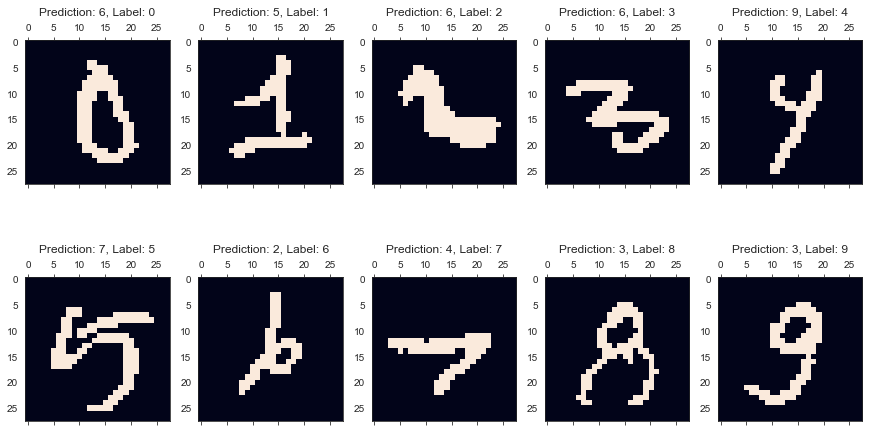


预测错误总数量:  153


In [24]:
print("错误分类(分类模型)：\n")
wc=[]
plt.figure(figsize=(15,8))

#选择数字0～9样本各一个进行展示
for i in range (10):
    for j in range(len(w)):
        if w[j][2]== i:
            wc.append(w[j])
            break

#输出预测错误
for i in range(0,len(wc)):
    ax=plt.subplot(2,5,i+1) 
    ax.matshow(wc[i][0])
    ax.set_title("Prediction: %(predict)d, Label: %(label)d\n"%{"predict":wc[i][1],"label":wc[i][2]})
plt.show()
print("\n预测错误总数量: ",len(w))

### 其次是回归模型的预测错误

错误分类(回归模型)：



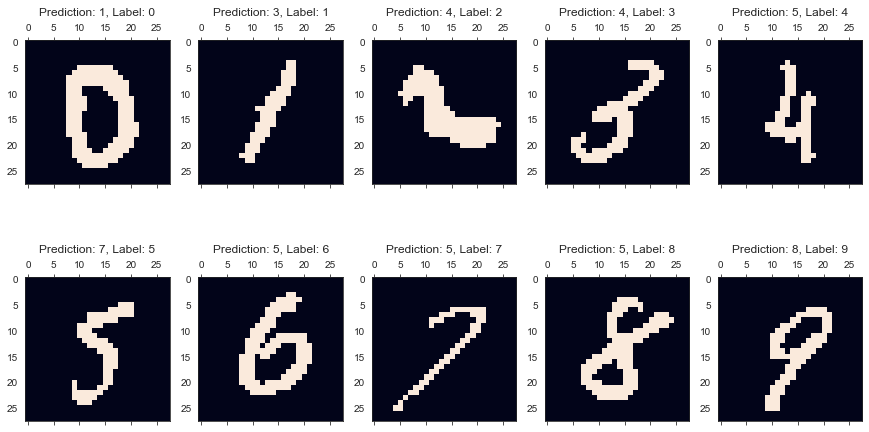


预测错误总数量:  1183


In [25]:
print("错误分类(回归模型)：\n")
w_rc=[]
plt.figure(figsize=(15,8))

#选择数字为0～9样本各一个进行展示
for i in range (10):
    for j in range(len(w_r)):
        if w_r[j][2]== i:
            w_rc.append(w_r[j])
            break

#输出预测错误
for i in range(0,len(w_rc)):
    ax=plt.subplot(2,5,i+1) 
    ax.matshow(w_rc[i][0])
    ax.set_title("Prediction: %(predict)d, Label: %(label)d\n"%{"predict":w_rc[i][1],"label":w_rc[i][2]})

plt.show()
print("\n预测错误总数量: ",len(w_r))

# <span id="6">6. 非数据库图片测试</span>

 <font size=4>使用下面4个手写图片进行预测</font>

<br/><center><font size=5 color=DodgerBlue>PRESENTED BY: BEILUN WANG</center>
<img src="hand_write_3.jpg" style="zoom:40%" />
<br/><center><font size=5 color=DodgerBlue>PRESENTED BY: QIAN WANG</center>
<img src="hand_write_4.jpg" style="zoom:50%" />
<center><font size=5 color=DodgerBlue>PRESENTED BY: YAN ZHANG</center>
<img src="hand_write_5.jpg" style="zoom:50%" />
<center><font size=5 color=DodgerBlue>PRESENTED BY: ZHENGXUAN LU</center>
<img src="hand_write_6.jpg" style="zoom:50%" />
<img src="hand_write_7.jpg" style="zoom:40%" />
<center><font size=5 color=DodgerBlue>PRESENTED BY: CHUNSHU LI</center>
<img src="hand_write_8.png" style="zoom:40%" />
    

### 非数据库图片预处理
图片需要进行预处理使模型可以处理它们。

In [26]:
#运用训练好的模型进行预测

#使用skimage进行图片读取和预处理
from skimage import io,data,transform    #skimage: conda install scikit-image
#目标尺寸大小
MNIST_SIZE = 28
#转换函数
def translate(image_path):
    #读入图片并变成灰度图
    img = io.imread(image_path, as_gray=True)
    #缩小到28*28 灰度取值范围为[0,255]
    translated_img = (1-transform.resize(img, (MNIST_SIZE, MNIST_SIZE)))*1000
    return translated_img



### 非数据库图片预测

非数据库图片预测


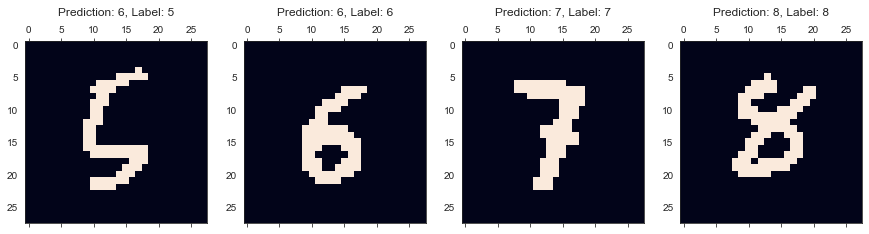

In [27]:
print("非数据库图片预测")
plt.figure(figsize=(15,10))

#每次预测图片前，需要对图片进行二值化
#PRESENTED BY: YAN ZHANG
hand_write_5=binarization(translate("hand_write_5.jpg"),30)
ax=plt.subplot(1,4,1)
ax.matshow(hand_write_5)
ax.set_title("Prediction: %(predict)d, Label: %(label)d\n"%{"predict":rfct.predict(hand_write_5.reshape(1,-1)),"label":5})

#PRESENTED BY YI ZHUANG
#已知输出易得1
#错误的预处理样例
hand_write_6=binarization(translate("hand_write_6.jpg"),128)
ax=plt.subplot(1,4,2)
ax.matshow(hand_write_6)
ax.set_title("Prediction: %(predict)d, Label: %(label)d\n"%{"predict":rfct.predict(hand_write_6.reshape(1,-1)),"label":6})

#PRESENTED BY ZHENGXUAN LU
hand_write_7=binarization(translate("hand_write_7.jpg"),80)
ax=plt.subplot(1,4,3)
ax.matshow(hand_write_7)
ax.set_title("Prediction: %(predict)d, Label: %(label)d\n"%{"predict":rfct.predict(hand_write_7.reshape(1,-1)),"label":7})

#PRESENTED BY CHUNSHU LI
hand_write_8=binarization(translate("hand_write_8.png"),40)
ax=plt.subplot(1,4,4)
ax.matshow(hand_write_8)
ax.set_title("Prediction: %(predict)d, Label: %(label)d\n"%{"predict":rfct.predict(hand_write_8.reshape(1,-1)),"label":8})

plt.show()


<center><font size=5 color=red>由于书写习惯等原因，预测和结果差距可能较大。</font></center>

### 使用摄像头拍摄手写数字进行预测。（不作要求）
>学习VideoCapture函数来调用摄像头
<br>通过摄像头获得手写数字图片，文件名为test.jpg。
<br>尽量将字迹写粗使特征容易被摄像头捕获。  

In [28]:
'''
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    frame=frame[int(((frame.shape[0]/2)-300)):int(((frame.shape[0]/2)+300)),
                int(((frame.shape[1]/2)-300)):int(((frame.shape[1]/2)+300)),0:3]
    cv2.namedWindow("resized",0);
    cv2.imshow("resized", frame)
    if cv2.waitKey(1) & 0xFF == ord('s'):
        cv2.imwrite("test.jpg", frame)
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
'''

'\ncap = cv2.VideoCapture(0)\nwhile True:\n    ret, frame = cap.read()\n    frame=frame[int(((frame.shape[0]/2)-300)):int(((frame.shape[0]/2)+300)),\n                int(((frame.shape[1]/2)-300)):int(((frame.shape[1]/2)+300)),0:3]\n    cv2.namedWindow("resized",0);\n    cv2.imshow("resized", frame)\n    if cv2.waitKey(1) & 0xFF == ord(\'s\'):\n        cv2.imwrite("test.jpg", frame)\n        break\n    if cv2.waitKey(1) & 0xFF == ord(\'q\'):\n        break\ncap.release()\ncv2.destroyAllWindows()\n'

**下面提供接口，您可以自己上传手写数字图片进行预测**

请您把需要测试的图片存入该教程的目录下。

可以使用的图片列表：

>hand_write_3.jpg
<br>hand_write_4.jpg
<br>hand_write_5.jpg
<br>hand_write_6.jpg
<br>hand_write_7.jpg
<br>hand_write_8.png
<br>hand_write_9.jpg

### <span id='HW5'>作业5：</span>
手写一个数字（画图/iPad/数位板）保存成图片，命名为"学号_姓名.jpg"在下面给出的接口进行测试，结果仅供图一乐。

Please input the name of the picture(需要后缀名,输入q退出): 2333.jpg
Please input the label of the picture: 3


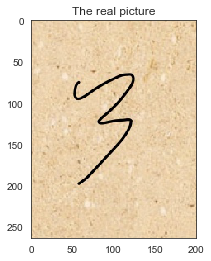

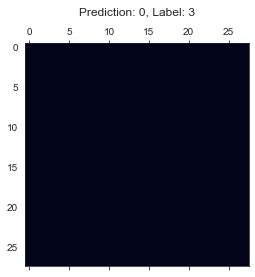

Please input the name of the picture(需要后缀名,输入q退出): 3333.jpg
Please input the label of the picture: 3


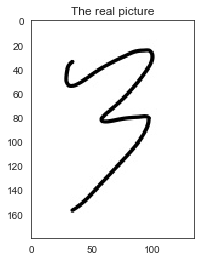

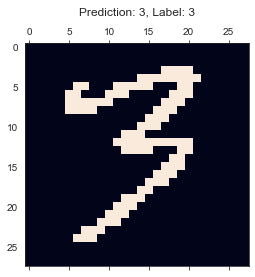

Please input the name of the picture(需要后缀名,输入q退出): q


In [29]:
#实现预测数字的函数，参数是所使用的模型
#需要把所用的图片上传至该项目的目录下
def predict_number(model):
    #输入文件名
    image_path=input("Please input the name of the picture(需要后缀名,输入q退出): ")
    if image_path=='q' or image_path=='Q':
        return False
    #输入标签
    elif os.path.exists(image_path)==False:
        print("没有这个文件名！请重新输入！")
        return True
    label=int(input("Please input the label of the picture: "))
    
    image=plt.imread(image_path)
    plt.title("The real picture")
    plt.imshow(image)
    
    image=binarization(translate(image_path),80)
    plt.matshow(image)
    plt.title("Prediction: %(predict)d, Label: %(label)d\n"%{"predict":model.predict(image.reshape(1,-1)),"label":label})
    plt.show()
    return True

sign=True
while sign:
    sign=predict_number(model=rfct)

# <span id="7">7. 总结</span>
### 在本课中，我们学习了：

>1. 决策树的概念
2. 分类决策树和回归决策树的概念和生成步骤
3. 随机森林的概念，随机森林的生成，超参数对随机森林的影响
4. 随机森林的运用：手写数字的识别

## [返回目录](#content)